# HW 3 - Regularization, Tree-based methods, Ensemble Learning

Complete the following questions and resubmit this entire notebook to canvas.
- For questions that ask you to derive or find a quantity use a __text cell__ to show your calculations.
 - Use markdown to write math expressions (as was done to create these problems) and make sure to show your work.
 - It doesnt have to be perfect looking but it needs to be readible.
 - You may also submit a legible picture of your derivation
- For questions that ask you compute something or write code use a __code cell__ to write your code.
 - You can create additional code cells as needed.
 - Just make sure your code is commented, the functions are named appropriately, and its easy to see your final answer.
- The total points on this homework is 100. Out of these 5 points are reserved for clarity of presentation,
punctuation and commenting with respect to the code.

__SUBMISSION__

When you submit you will submit a pdf file __and__ the notebook file. The TA will use the pdf file to grade more quickly. The notebook file is there to confirm your work.

To generate a pdf file
1. Click File
2. Click print
3. Set the destinationas "save as pdf"
4. Hit print

Title the pdf file `LASTNAME-FIRSTNAME-HW3.pdf`
Title your notebook file as `LASTNAME-FIRSTNAME-HW3.ipynb`

Submit both files.



In [97]:
# libraries and functions you may find useful
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

## Q1 - Curse of Dimensionality (15 points)

### Part 1: Visualization (8 points)
1. For each of the specified dimensions \( p = 2, 10, 100, 1000 \), draw a sample of size \( n = 100 \) from a uniform distribution on the interval [0, 1] for each dimension. This can be done using the `np.random.uniform` function in Python.
2.For each sample, compute the Euclidean distance between every pair of points $ (x_i, x_j) $ where $ i < j $. Use the following formula for Euclidean distance between two points $ x_i $ and $ x_j $ in a p-dimensional space:
   $$
   ||x_i - x_j||_2 = \sqrt{\sum_{k=1}^p (x_{ik} - x_{jk})^2}
   $$
3. For each dimension $p$, create a histogram of the computed Euclidean distances. Each dimension's distances should be visualized in a separate histogram.

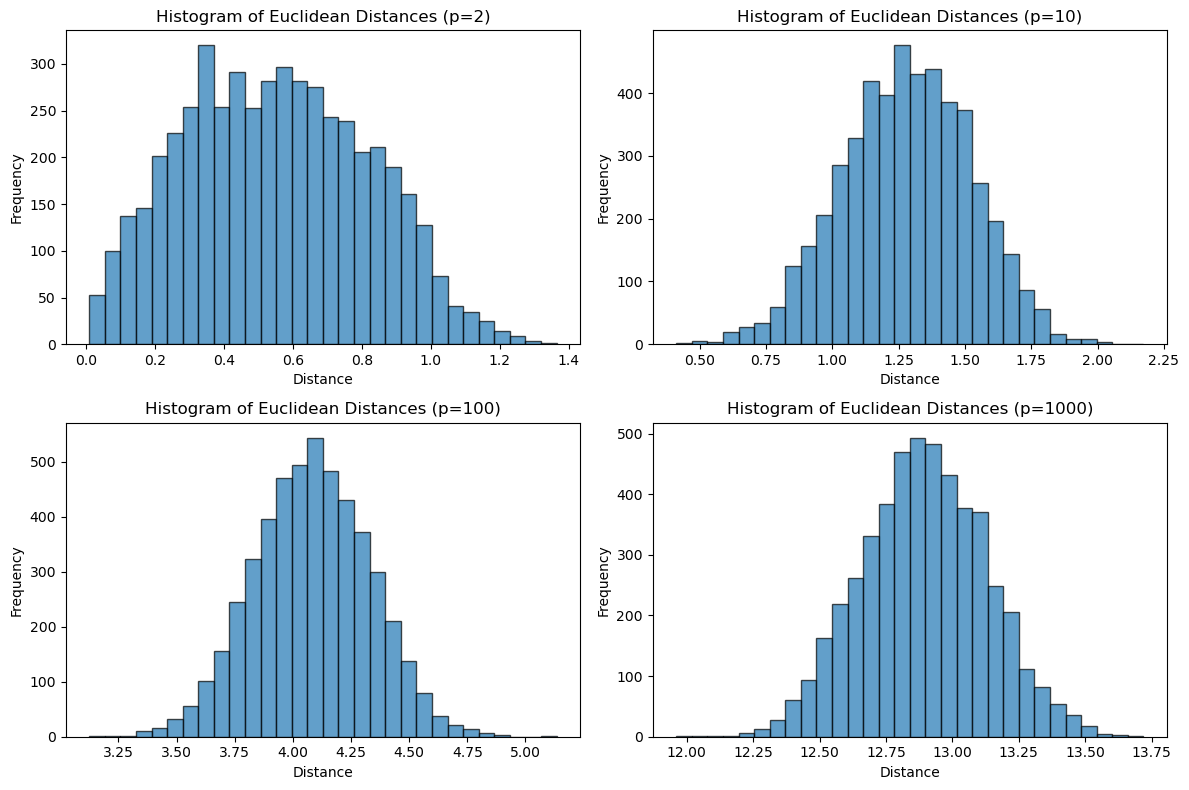

In [98]:
#Part 1: Visualization

#1
# Define the dimensions (p = 2, 10, 100, 1000)
p = [2, 10, 100, 1000]

def generate_samples(p, n=100):
    return torch.rand((n, p)) # uniform distribution

def euclidean_distance(samples):
    n = samples.shape[0] # number of samples
    distances = [] # store distances between pairs of samples
    for i in range(n):
        for j in range(i + 1, n):
            dist = torch.norm(samples[i] - samples[j], p=2).item() # Euclidean distance
            distances.append(dist) # store the distance
    return distances

#2
# Plot histograms of Euclidean distances
def plot_histograms(dimensions, n=100):
    plt.figure(figsize=(12, 8))
    
    for i, p in enumerate(dimensions, 1):
        samples = generate_samples(p, n)
        distances = euclidean_distance(samples)
        
        plt.subplot(2, 2, i)
        plt.hist(distances, bins=30, edgecolor='black', alpha=0.7)
        plt.title(f'Histogram of Euclidean Distances (p={p})')
        plt.xlabel('Distance')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Visualize the histograms
plot_histograms(p)

### Part 2: Discussion (7 points)
1. How does the distribution of distances change as the dimensionality increases? What do these changes suggest about the spacing of points in high-dimensional spaces?
2. Based on your observations, discuss the potential challenges and effectiveness of local prediction methods like KNN in high-dimensional spaces.

#### 1. 

As the number of dimensions increases, the distances between points tend to appear more normal and uniform. In lower dimensions, there's a wider range of distances, but in higher dimensions, most distances are similar. This means that points become more spread out, in high-dimensional spaces.

#### 2. 

 Based on the observations from the histograms above a challenge for a method like KNN, could be finding the "closest" points. Since all points are similar in distance in high-dimensional spaces, distinguishing between relevant and irrelevant neighbors becomes difficult. As a result, KNN can struggle with accuracy and efficiency, making it less effective in very high-dimensional problems.

## Q2 - Regularization (25 points)



In the class, we have discussed Ridge and LASSO regression.
Later we will use a fake dataset to illustrate how penalization works. Please do not change the seed.

In [99]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

np.random.seed(0)

# random features (100 observations, 400 features)
x = np.random.normal(0, 1, [200, 400])

# only 5 features are relevant (non-zero coefficient)
beta = np.concatenate([2 * np.ones(5), np.zeros(395)]).reshape(-1, 1)

# outcome variable
y = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])

x = torch.tensor(x)
y = torch.tensor(y)

### part 1 - Ridge (9 points)

A ridge penalty is defined as $\lambda \sum_{j = 1}^p \beta_j^2$. If we modify the mean square error (MSE) to have a ridge penalty then the full loss function is

$$\mathcal{L} = \frac{1}{n}\sum_{i = 1}^n (y_i - x_i\beta)^2 + \lambda \sum_{j = 1}^p \beta_j^2$$

where $\beta_j$ denotes the $j$th entry of $\beta$.

1. Define a new loss function `mse_ridge()` which computes the above loss for a given value of $\lambda$ (you choose $\lambda$). Hint: `lambda` is a reserved keyword in Python so use `lam` instead.

2. Using the above loss fit three models. One where $\lambda = 0$, one where $\lambda = 2$ and one where $\lambda = 10$. Plot the estimated $\beta$ vector for each model. Do you notice any systematic differences when changing $\lambda$ from a small to a large number?

3. Recall that the point of ridge penalization is encourage $\beta$ to be small. Why would setting $\lambda$ to a negative number actually encourage large $\beta$ values instead? Think about what happens when you minimize the loss.

In [100]:
def mse_ridge(model, x, y, lam):
    mse_loss = torch.mean((y - model(x)) ** 2)  # Compute MSE
    ridge_penalty = lam * torch.sum(model.beta ** 2)  # L2 regularization
    return mse_loss + ridge_penalty


In [101]:
# Define Ridge Regression model
class RidgeRegression(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.beta = nn.Parameter(torch.randn(n_features, 1) * 0.01)  # Initialize coefficients

    def forward(self, x):
        return x @ self.beta  # Linear model


In [102]:
#T rain Ridge Regression model
def train_ridge(x, y, lam, lr=0.1, epochs=1000):
    model = RidgeRegression(n_features=x.shape[1])
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    losses = []
    for _ in trange(epochs, desc=f"Training Ridge (λ={lam})"):
        loss = mse_ridge(model, x, y, lam)  # Compute loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return model.beta.detach().numpy(), losses


Training Ridge (λ=0):   0%|          | 0/1000 [00:00<?, ?it/s]

Training Ridge (λ=2):   0%|          | 0/1000 [00:00<?, ?it/s]

Training Ridge (λ=10):   0%|          | 0/1000 [00:00<?, ?it/s]

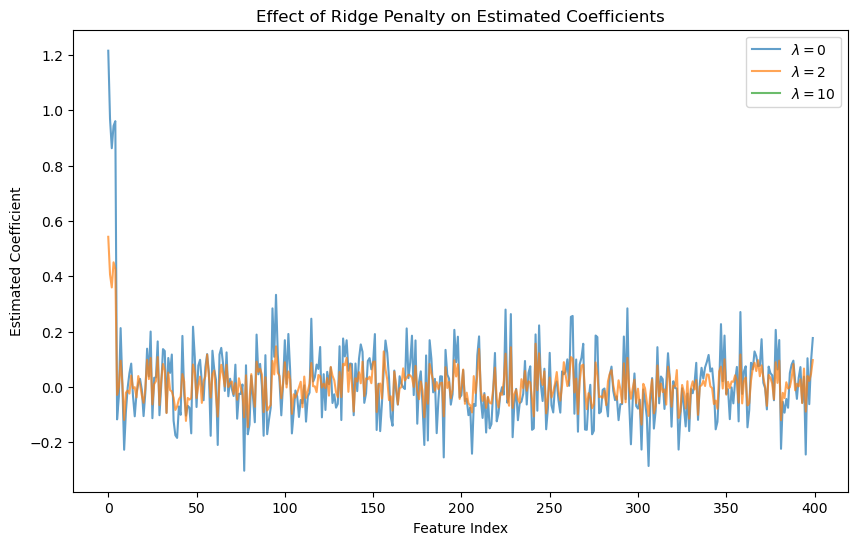

In [103]:
# plot betas

# Convert x and y to float32
x = x.float()
y = y.float()

# Train models for different λ values
beta_0, loss_0 = train_ridge(x, y, lam=0)
beta_2, loss_2 = train_ridge(x, y, lam=2)
beta_10, loss_10 = train_ridge(x, y, lam=10)

# Plot estimated coefficients for different λ values
plt.figure(figsize=(10, 6))
plt.plot(beta_0, label=r"$\lambda = 0$", alpha=0.7)
plt.plot(beta_2, label=r"$\lambda = 2$", alpha=0.7)
plt.plot(beta_10, label=r"$\lambda = 10$", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("Estimated Coefficient")
plt.legend()
plt.title("Effect of Ridge Penalty on Estimated Coefficients")
plt.show()



2. A difference when changing lambda from a smaller to larger value is the estimated beta value has less variance as the feature index changes. 

3. A negative lambda would reward larger beta values which is the opposite of what the regularization is trying to achieve. Thus, it will be unstable in minimizing the loss. 

### part 2 - LASSO (9 points)

A LASSO penalty is defined as $\lambda \sum_{j = 1}^p |\beta_j|$. If we modify the mean square error (MSE) to have a LASSO penalty then the full loss function is

$$\mathcal{L} = \frac{1}{n}\sum_{i = 1}^n (y_i - x_i\beta)^2 + \lambda \sum_{j = 1}^p |\beta_j|$$

where $\beta_j$ denotes the $j$th entry of $\beta$.

1. Define a new loss function `mse_lasso()` which computes the above loss for a given value of $\lambda$ (you choose $\lambda$).

2. Using the above loss fit three models. One where $\lambda = 0$, one where $\lambda = 2$ and one where $\lambda = 10$. Plot the estimated $\beta$ vector for each model. Do you notice any systematic differences when changing $\lambda$ from a small to a large number?


In [104]:
def mse_lasso(model, x, y, lam):
    mse_loss = torch.mean((y - model(x)) ** 2)  # Compute MSE
    lasso_penalty = lam * torch.sum(torch.abs(model.beta))  # L1 regularization
    return mse_loss + lasso_penalty

In [105]:
# Define Lasso Regression model
class LassoRegression(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.beta = nn.Parameter(torch.randn(n_features, 1) * 0.01)  # Initialize coefficients

    def forward(self, x):
        return x @ self.beta  # Linear model

In [106]:
# Train Lasso Regression model
def train_lasso(x, y, lam, lr=0.1, epochs=1000):
    model = LassoRegression(n_features=x.shape[1])
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    losses = []
    for _ in trange(epochs, desc=f"Training Lasso (λ={lam})"):
        loss = mse_lasso(model, x, y, lam)  # Compute loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return model.beta.detach().numpy(), losses

Training Lasso (λ=0):   0%|          | 0/1000 [00:00<?, ?it/s]

Training Lasso (λ=2):   0%|          | 0/1000 [00:00<?, ?it/s]

Training Lasso (λ=10):   0%|          | 0/1000 [00:00<?, ?it/s]

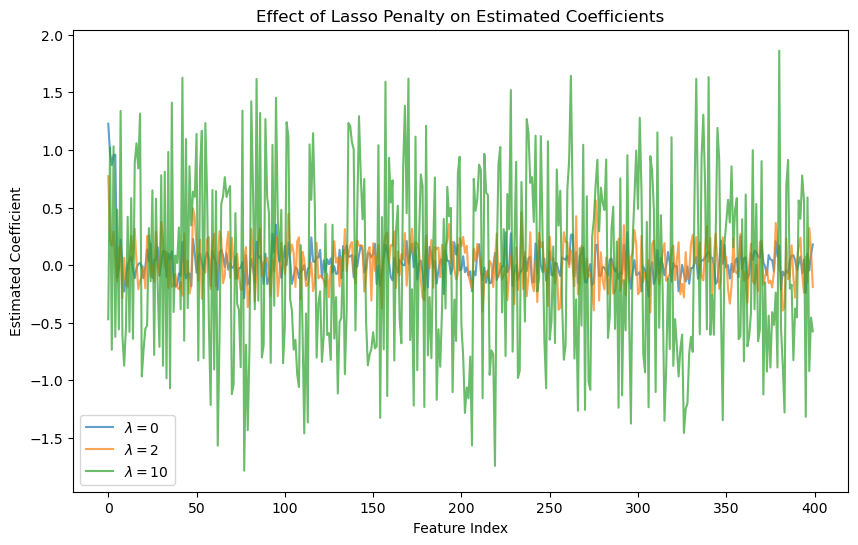

In [107]:
# plot betas

# Convert x and y to float32
x = x.float()
y = y.float()

# Train models for different λ values
beta_0, loss_0 = train_lasso(x, y, lam=0)
beta_2, loss_2 = train_lasso(x, y, lam=2)
beta_10, loss_10 = train_lasso(x, y, lam=10)

# Plot estimated coefficients for different λ values
plt.figure(figsize=(10, 6))
plt.plot(beta_0, label=r"$\lambda = 0$", alpha=0.7)
plt.plot(beta_2, label=r"$\lambda = 2$", alpha=0.7)
plt.plot(beta_10, label=r"$\lambda = 10$", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("Estimated Coefficient")
plt.legend()
plt.title("Effect of Lasso Penalty on Estimated Coefficients")
plt.show()


2.  A systematic difference that can be seen is the higher the lambda to greater the vairance in the estimated beta value. This is difference in nature to the ridge approach above. 

### part 3 - Compare (7 points)

Compute the test MSE for each of the 6 models (3 ridge models and 3 LASSO models). Which model performed the best?

In [108]:
### Simulate testing dataset
np.random.seed(1)

# only 5 features are relevant (non-zero coefficient)
beta = np.concatenate([2 * np.ones(5), np.zeros(395)]).reshape(-1, 1)

## resimulate a test dataset
x_test = x
y_test = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])

/var/folders/1x/d63v0p1x0t7cpz8_8l_1n7rm0000gn/T/ipykernel_32769/1687070071.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_test = x @ beta + 0.1 * np.random.normal(0, 1, [200, 1])


In [109]:
# write some code here
def test_mse(beta_hat, x_test, y_test):
    y_pred = x_test @ torch.tensor(beta_hat, dtype=torch.float32)
    mse = torch.mean((y_test - y_pred) ** 2).item()
    return mse

In [110]:
# Compute test MSE for Ridge models
ridge_mse_0 = test_mse(beta_0, x_test, y_test)
ridge_mse_2 = test_mse(beta_2, x_test, y_test)
ridge_mse_10 = test_mse(beta_10, x_test, y_test)

# Compute test MSE for Lasso models
lasso_mse_0 = test_mse(beta_0, x_test, y_test)
lasso_mse_2 = test_mse(beta_2, x_test, y_test)
lasso_mse_10 = test_mse(beta_10, x_test, y_test)

# Print results
print(f"Test MSE for Ridge (λ=0): {ridge_mse_0:.4f}")
print(f"Test MSE for Ridge (λ=2): {ridge_mse_2:.4f}")
print(f"Test MSE for Ridge (λ=10): {ridge_mse_10:.4f}")
print(f"Test MSE for Lasso (λ=0): {lasso_mse_0:.4f}")
print(f"Test MSE for Lasso (λ=2): {lasso_mse_2:.4f}")
print(f"Test MSE for Lasso (λ=10): {lasso_mse_10:.4f}")

Test MSE for Ridge (λ=0): 0.0153
Test MSE for Ridge (λ=2): 55.0443
Test MSE for Ridge (λ=10): 1058.8542
Test MSE for Lasso (λ=0): 0.0153
Test MSE for Lasso (λ=2): 55.0443
Test MSE for Lasso (λ=10): 1058.8542


3. Comparing the test MSE for all 6 models, both ridge and lasso provide the same MSE for the same lambda. Also, we can see that the lowest MSE was the same for both Ridge and Lasso lambda = 0. This value of 0.0153, is too different from the other MSE found, leading me to believe that these values are overfitted and that lambda = 0 is not the best option for the models. I believe that lambda = 2 for either Ridge or Lasso will be the best for the model. 

## Q3 - Multi-target Classification with Regularization (30 points)

We will use a "rectangles" dataset to test out our method. Your task is simple. Given an image classify whether it contains a blue rectangle, a red rectangle, a green rectangle, or no rectangle. We will generate this dataset below so please do not change the seeds.


### Recall: multi-target logistic regression

A multi-target logistic regression when we have $k$ categories is defined as
\begin{align}
y_i &\sim Categorical((p_1,...,p_k)_i) \\
(p_1,...,p_k)_i &= \sigma(x_i\beta + \alpha)
\end{align}

How to read this:
1. Take a $p$ dimensional input vector $x_i$ and multiple it by the __matrix__ $\beta_{p \times k}$ then add the vector $\alpha_{1\times k}$ to get a $k$ dimensional vector of log probabilties

2. Squash the log probabilities $z_i = x_i\beta + \alpha$ to all be between 0 and 1, and sum to 1, by applying the __softmax function__ $\sigma(\cdot)$. The $j$'th entry $(j = 1,...,k)$ of $\sigma(z_i)$ is equal to
$$
\sigma(z_i)_j = \frac{\exp((z_i)_j)}{\sum_{j = 1}^k\exp((z_i )_j)}
$$
where $((z_i)_j)$ means the  $j$'th entry of $z_i$.

3. We say $y_i$ belongs to class $j$ with probability $\sigma(z_i)_j$

Also recall:
We represent $Y_{n\times1}$ as a $Y_{n\times k}$ one-hot encoded matrix so that we can derive the __multi-target CE loss__ function from the categorical distribution as

\begin{align}
\mathcal{L}(\beta) &= -\frac{1}{nk}\sum_{i=1}^n \sum_{j=1}^k y_{i,j} \log(\sigma(x_i \beta))_j \\
\end{align}

In [111]:
%pip install scikit-image --upgrade

from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from skimage.draw import random_shapes
from skimage.util import random_noise

Note: you may need to restart the kernel to use updated packages.


Generate the rectangle data below

In [112]:
m1, m2, m3, m4 = 200, 200, 200, 200
n = m1 + m2 + m3 + m4

rng = 0

## generate blues
blue_imgs = []
for _ in trange(m1):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((20, 20),(20,20),(255,255)),
                         rng = rng
                         )

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  blue_imgs.append(img)
  rng += 1

blue_imgs = np.array(blue_imgs)
blue_labs = 0*np.ones(m1)

## generate reds
red_imgs = []
for _ in trange(m2):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((255,255),(20, 20),(20,20)),
                         rng = rng)

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  red_imgs.append(img)
  rng += 1

red_imgs = np.array(red_imgs)
red_labs = 1*np.ones(m2)

## generate greens
green_imgs = []
for _ in trange(m3):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((20, 20),(255,255),(20,20)),
                         rng = rng)

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  green_imgs.append(img)
  rng += 1

green_imgs = np.array(green_imgs)
green_labs = 2*np.ones(m3)

## generate blanks
none_imgs = []
for _ in trange(m4):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((255, 255),(255,255),(255,255)),
                         rng = rng)

  img = random_noise(img, mode='speckle', var = 0.03, rng = rng)
  none_imgs.append(img)
  rng += 1

none_imgs = np.array(none_imgs)
none_labs = 3*np.ones(m4)

imgs = np.vstack([blue_imgs, red_imgs, green_imgs, none_imgs])
labs = np.concatenate([blue_labs, red_labs, green_labs, none_labs]).astype(np.int64)
np.random.seed(0)
idx = np.random.permutation(np.arange(n))
imgs = imgs[idx]
labs = labs[idx]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

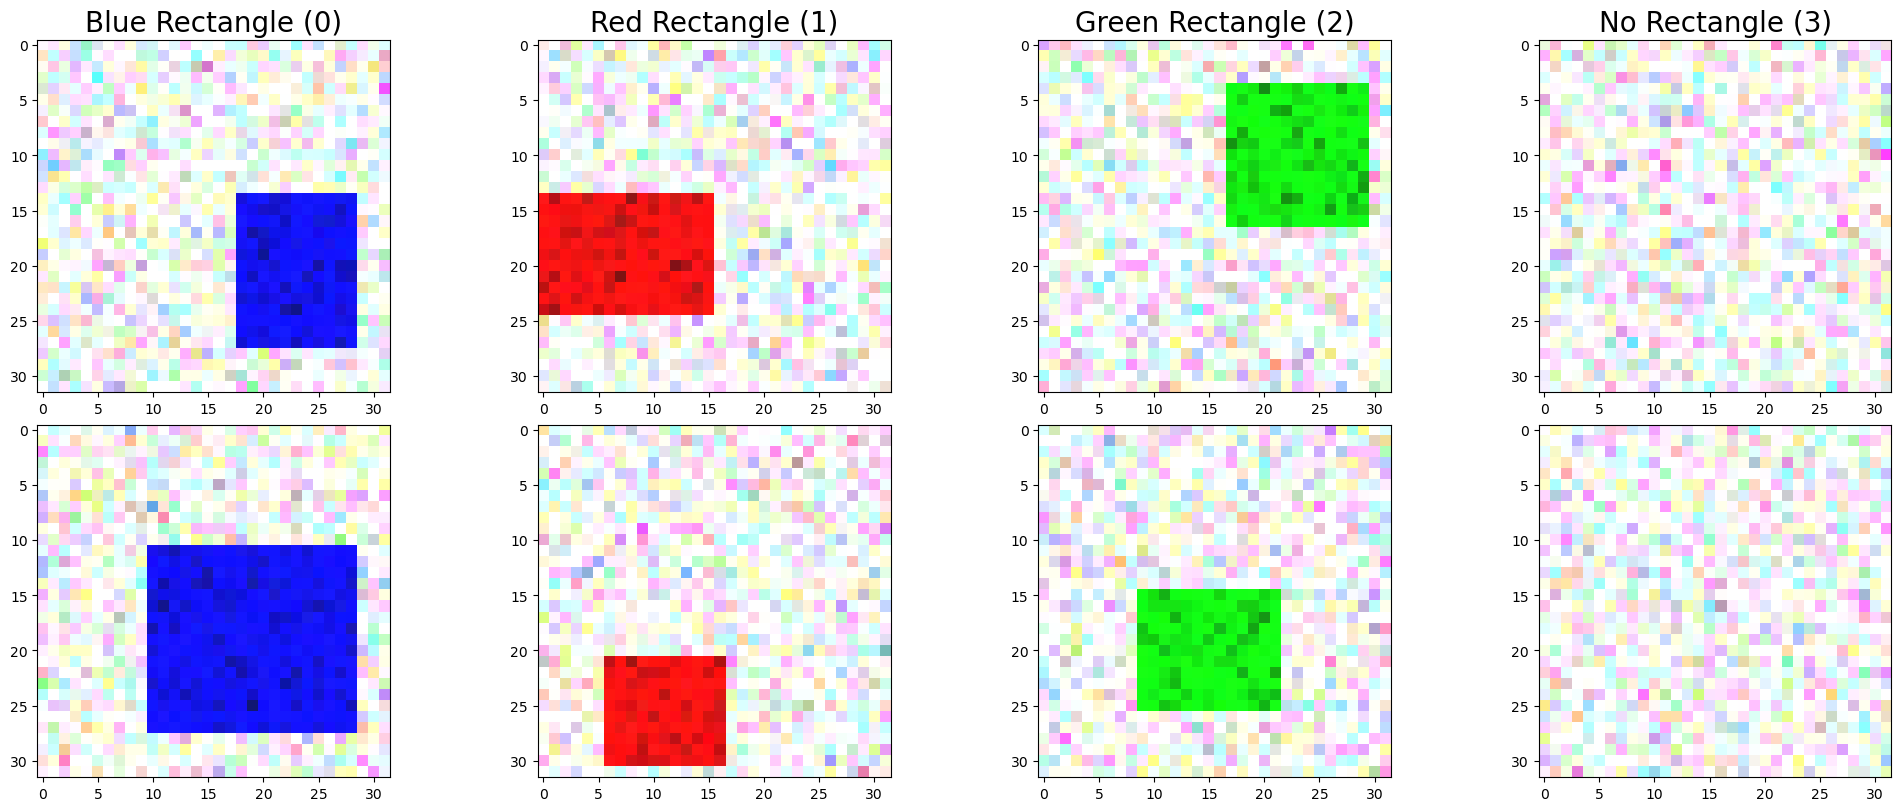

In [113]:
fig, ax = plt.subplots(2, 4, constrained_layout = True, figsize = (20, 8))
ax[0,0].imshow(blue_imgs[0])
ax[0,1].imshow(red_imgs[0])
ax[0,2].imshow(green_imgs[0])
ax[0,3].imshow(none_imgs[0])

ax[1,0].imshow(blue_imgs[1])
ax[1,1].imshow(red_imgs[1])
ax[1,2].imshow(green_imgs[1])
ax[1,3].imshow(none_imgs[1])

ax[0,0].set_title('Blue Rectangle (0)', fontsize = 20)
ax[0,1].set_title('Red Rectangle (1)', fontsize = 20)
ax[0,2].set_title('Green Rectangle (2)', fontsize = 20)
ax[0,3].set_title('No Rectangle (3)', fontsize = 20)
plt.show()

The above plots show an example of each class. We code blue as 0, red as 1, green as 2, and none as 3. Each image contains a fair amount of degredation and rectangles are randomly generated somewhere in the image with a random size.

In [114]:
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split

x = torch.tensor(imgs).reshape(n, -1)
y = one_hot(torch.tensor(labs))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

### part 1 - Implement the model (8 points)

Let's use our `MultiLogisticRegression` class you previously created from homework 2. This class should do the following

1. Automatically determine the shapes of $\beta$ and $\alpha$ from the data `x` and `y`
2. Initialize $\alpha$ and $\beta$ at 0 and enable gradient tracking
3. Include a `forward()` function that computes class probabilities given input `x`
4. Include a `classify()` function that classifies inputs `x`, i.e. return the class with the highest probability.


To make sure its working. Instantiate your class and call the forward function on `x_train`. Print the output (it should be a tensor of all $0.25$)


In [115]:
## numerical minimization
import torch
import torch.nn as nn

class MultiLogisticRegression(nn.Module):
    def __init__(self, x, y):
      super(MultiLogisticRegression, self).__init__()
      # Get number of features and classes from x and y
      n_features = x.shape[1]
      n_classes = y.shape[1]

      # Initialize parameters: β (weights) and α (bias)
      self.beta = nn.Parameter(torch.zeros(n_features, n_classes, dtype=torch.float32))
      self.alpha = nn.Parameter(torch.zeros(1, n_classes, dtype=torch.float32))

    def forward(self, x):
      logits = x @ self.beta + self.alpha  # Compute logits
      probabilities = torch.softmax(logits, dim=1)  # Apply softmax
      return probabilities

    def classify(self, x):
      probabilities = self.forward(x)  # Compute probabilities
      class_preds = torch.argmax(probabilities, dim=1)  # Get class with highest probability
      return class_preds

### Part 2 - Training (15 points)

1. Train three multi-target logisitic regression models on the rectangles dataset to classify images of rectangles. Use the model above and write your own loss functions. Write your own gradient descent loop. Fit the three models by training with
  1. cross entropy
  2. cross entropy with a ridge penalty
  3. cross entropy with a LASSO penalty

2. Plot the loss trace (did it converge?) for each model and print the test __accuracy__ and __cross entropy__ for each model. The test accuracy needs to be above $0.97$ for at least one of these models. State which model performed the best on test in terms of cross entropy or accuracy.

3. Extra 5 points if you achieve a test accuracy over $0.994$ (its possible)

_hint 1: Try 1000-3000 training iterations with a learning rate between 1e-2 and 1e-3_

_hint 2: Consider using a mean rather than a sum in your ridge/lasso penalties to automatically scale the penalty by the sample size_

In [116]:
from torch.nn import functional as F
# Custom loss functions

# Cross-entropy loss
def cross_entropy_loss(y_pred, y_true):
    return F.cross_entropy(y_pred, y_true)

# Ridge loss
def ridge_loss(beta, lambda_):
    return lambda_ * torch.sum(beta**2)

# Lasso loss
def lasso_loss(beta, lambda_):
    return lambda_ * torch.sum(torch.abs(beta))

In [117]:
import torch.optim as optim

# Gradient descent loop function
def train_model(model, x_train, y_train, num_iterations, lr, lambda_=0.0, penalty_type=None):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_trace = []
    
    for i in range(num_iterations):
        model.train()
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        probabilities = model(x_train)
        
        # Calculate loss
        ce_loss = cross_entropy_loss(probabilities, y_train)
        
        # Apply regularization penalties
        if penalty_type == "ridge":
            loss = ce_loss + ridge_loss(model.beta, lambda_)
        elif penalty_type == "lasso":
            loss = ce_loss + lasso_loss(model.beta, lambda_)
        else:
            loss = ce_loss
        
        # Backward pass (gradient calculation)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Track loss
        loss_trace.append(loss.item())
    
    return loss_trace

In [118]:
# Train and evaluate models
num_iterations = 2000
learning_rate = 1e-3
lambda_penalty = 0.1  # Adjust based on experimentation

# Convert x_train and y_train to float32
x_train = x_train.float()
y_train = y_train.float()

# Model 1: Cross entropy loss (no penalty)
model1 = MultiLogisticRegression(x_train, y_train)
loss_trace1 = train_model(model1, x_train, y_train, num_iterations, learning_rate)

# Model 2: Cross entropy with ridge penalty
model2 = MultiLogisticRegression(x_train, y_train)
loss_trace2 = train_model(model2, x_train, y_train, num_iterations, learning_rate, lambda_penalty, penalty_type="ridge")

# Model 3: Cross entropy with lasso penalty
model3 = MultiLogisticRegression(x_train, y_train)
loss_trace3 = train_model(model3, x_train, y_train, num_iterations, learning_rate, lambda_penalty, penalty_type="lasso")

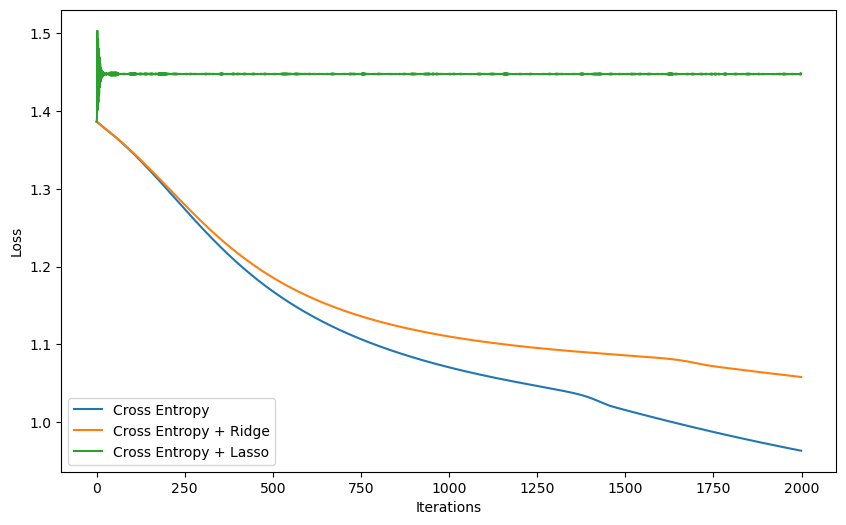

In [119]:
# Plot loss traces
plt.figure(figsize=(10, 6))
plt.plot(loss_trace1, label="Cross Entropy")
plt.plot(loss_trace2, label="Cross Entropy + Ridge")
plt.plot(loss_trace3, label="Cross Entropy + Lasso")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [120]:
from sklearn.metrics import accuracy_score

# Test accuracy and cross entropy loss
def evaluate_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        x_test = x_test.float()
        y_test = y_test.float()
        probabilities = model(x_test)
        _, predicted = torch.max(probabilities, 1)
        _, actual = torch.max(y_test, 1)
        
        accuracy = accuracy_score(actual.numpy(), predicted.numpy())
        ce_loss = cross_entropy_loss(probabilities, y_test).item()
    
    return accuracy, ce_loss

# Evaluate models
acc1, ce1 = evaluate_model(model1, x_test, y_test)
acc2, ce2 = evaluate_model(model2, x_test, y_test)
acc3, ce3 = evaluate_model(model3, x_test, y_test)

# Print the test accuracy and cross entropy loss for each model
print(f"Model 1: Accuracy = {acc1:.4f}, Cross Entropy = {ce1:.4f}")
print(f"Model 2: Accuracy = {acc2:.4f}, Cross Entropy = {ce2:.4f}")
print(f"Model 3: Accuracy = {acc3:.4f}, Cross Entropy = {ce3:.4f}")

# Identify best model
best_model = None
best_accuracy = max(acc1, acc2, acc3)
best_ce = min(ce1, ce2, ce3)

if best_accuracy == acc1:
    best_model = "Model 1"
elif best_accuracy == acc2:
    best_model = "Model 2"
else:
    best_model = "Model 3"

print(f"Best model based on accuracy: {best_model} with accuracy {best_accuracy:.4f} and cross entropy {best_ce:.4f}")


Model 1: Accuracy = 0.9773, Cross Entropy = 0.9734
Model 2: Accuracy = 0.9886, Cross Entropy = 1.0210
Model 3: Accuracy = 0.2576, Cross Entropy = 1.3859
Best model based on accuracy: Model 2 with accuracy 0.9886 and cross entropy 0.9734


5. The model 2 and 3 of cross entropy with ridge or lasso added both converged. However, model 1 and 2 had Accuracy above 0.97. From these two metrics the best model based on both values is model 2: cross entropy with ridge. 

### Part 3 - Evaluate (7 points)

1. Check the classification report for whichever model performed the best. Are there any colors (classes) that your model performed particularly poorly on? How might you improve your model on specific classes?

In [121]:
from sklearn.metrics import classification_report

best_model = model2  # Replace this with the best-performing model from earlier

# Convert x_test and y_test to float32
x_test = x_test.float()
y_test = y_test.float()

# Get predictions
best_model.eval()
with torch.no_grad():
    probabilities = best_model(x_test)
    _, predicted = torch.max(probabilities, 1)
    _, actual = torch.max(y_test, 1)

# Generate classification report
report = classification_report(actual.numpy(), predicted.numpy())
print(report)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98        67
           1       1.00      1.00      1.00        63
           2       1.00      0.99      0.99        68
           3       0.96      1.00      0.98        66

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264



1. Classes that model 2 performed the overall worst is class 3 due to its lower precision and f1-score. Regardless all class including 3 had metrics above 0.95 which a 0.99 weighted avg for precision, recall, and f1-score. For improving the model, a start would be to improve class 3 through applying targeted adjustments in the training. 

## Q4 Tree-based Method and Ensembling (25 points)

In this problem our goal is to estimate the popularity of online articles published over the last years. The provided data contain articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks, which approximates the popularity of an article.

We will use the dataset from UCI machine learning database:
https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity#


In [122]:
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [123]:
### download the dataset
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_news_popularity = fetch_ucirepo(id=332)

In [124]:
# data (as pandas dataframes)
x = online_news_popularity.data.features
y = online_news_popularity.data.targets

# metadata
print(online_news_popularity.metadata)

{'uci_id': 332, 'name': 'Online News Popularity', 'repository_url': 'https://archive.ics.uci.edu/dataset/332/online+news+popularity', 'data_url': 'https://archive.ics.uci.edu/static/public/332/data.csv', 'abstract': 'This dataset summarizes a heterogeneous set of features about articles published by Mashable in a period of two years. The goal is to predict the number of shares in social networks (popularity).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 39797, 'num_features': 58, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': [' shares'], 'index_col': ['url'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Thu Feb 15 2024', 'dataset_doi': '10.24432/C5NS3V', 'creators': ['Kelwin Fernandes', 'Pedro Vinagre', 'Paulo Cortez', 'Pedro Sernadela'], 'intro_paper': {'ID': 390, 'type': 'NATIVE', 'title': 'A Proactive Intelligent Decisio

In [125]:
# variable information
x.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,4.548239,...,0.353825,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064
std,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,0.844406,...,0.104542,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.478404,...,0.306244,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000
50%,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664082,...,0.358755,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000
75%,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,...,0.411428,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000
max,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,8.041534,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000


In [126]:
y.describe()

,shares
count,39644.000000
mean,3395.380184
std,11626.950749
min,1.000000
25%,946.000000
50%,1400.000000
75%,2800.000000
max,843300.000000


In [127]:
## scale the target
y = np.log(y+1)
y.describe()

,shares
count,39644.000000
mean,7.475692
std,0.929674
min,0.693147
25%,6.853299
50%,7.244942
75%,7.937732
max,13.645079


In [128]:
# train, test, val
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

### scale inputs (optional for tree-based method)
x_mean = np.mean(xtrain, axis = 0)
x_sd = np.std(xtrain, axis = 0)

xtrain = (xtrain - x_mean) / x_sd
xtest = (xtest - x_mean) / x_sd

xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

In [129]:
ytrain = np.array(ytrain).reshape(-1, 1)
ytest = np.array(ytest).reshape(-1, 1)
yval = np.array(yval).reshape(-1, 1)

In [130]:
xtrain.shape

(25372, 58)

In [131]:
xtrain.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
19052,0.281576,-0.330111,0.004375,-0.000485,0.001385,1.157086,-0.077491,0.653367,-0.301914,0.322553,...,0.185052,0.072069,0.172098,-0.136021,0.076074,0.426530,1.183743,0.983073,-0.928867,0.777279
18023,0.752976,-0.399793,0.028412,-0.000485,0.045517,0.097684,-0.338939,-0.427951,-0.301914,0.113234,...,-1.559626,-0.458901,-1.540609,0.485643,0.420422,0.993259,0.361687,-1.766076,-1.282312,1.070557
16532,0.281576,3.445341,-0.054580,-0.000485,-0.052454,4.864993,3.059894,3.296587,-0.301914,0.125536,...,0.775566,-0.458901,0.978078,0.155794,-0.956971,0.600908,0.361687,-0.641425,-1.282312,-0.249193
38998,0.752976,-0.784095,0.030578,-0.000485,0.028822,-0.696868,-0.077491,-0.427951,-0.061705,0.020574,...,0.037579,0.072069,0.172098,-0.415508,0.721726,-2.145549,0.780055,0.804557,-1.623133,0.567795
23063,-1.132623,-0.881226,0.052704,-0.000485,0.042707,-0.343734,0.183958,-0.548097,0.178503,0.082371,...,0.131063,0.586949,-1.036872,0.466053,1.109118,-0.968496,-0.871396,-0.266541,0.838354,-0.689110


### Part 1 - Decision Tree Regression (9 points)
Estimate the number of shares of an article on the test data using a decision tree regressor `DecisionTreeRegressor`.

1. Train your regression tree with different depth of the decision tree (use `max_depth`). Please at least try three diffenrent depth. Then use the validation dataset to determine the optimal depth of the decision tree.
2. For your final model, report the MSE on your training, validation and test dataset.



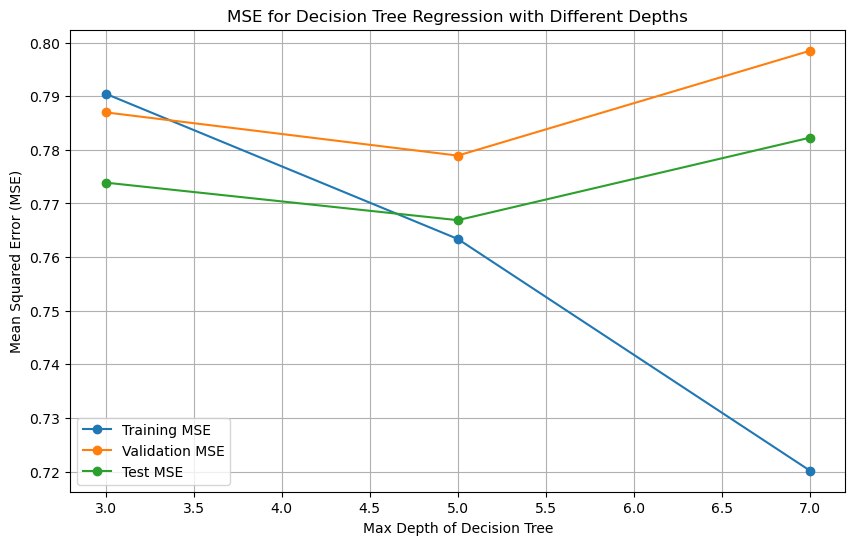

Optimal Depth: 5


In [132]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


# List of different depths to try
depths = [3, 5, 7]

# Store results
train_errors = []
val_errors = []
test_errors = []

# Train Decision Trees with different max_depth values
for depth in depths:
    # Initialize the model with a specific max_depth
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Train the model
    model.fit(xtrain, ytrain)
    
    # Predict on training, validation, and test sets
    ytrain_pred = model.predict(xtrain)
    yval_pred = model.predict(xval)
    ytest_pred = model.predict(xtest)
    
    # Calculate MSE for training, validation, and test sets
    train_mse = mean_squared_error(ytrain, ytrain_pred)
    val_mse = mean_squared_error(yval, yval_pred)
    test_mse = mean_squared_error(ytest, ytest_pred)
    
    # Append results
    train_errors.append(train_mse)
    val_errors.append(val_mse)
    test_errors.append(test_mse)

# Plot MSE for different depths
plt.figure(figsize=(10, 6))
plt.plot(depths, train_errors, label="Training MSE", marker='o')
plt.plot(depths, val_errors, label="Validation MSE", marker='o')
plt.plot(depths, test_errors, label="Test MSE", marker='o')
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for Decision Tree Regression with Different Depths")
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal depth (minimizing validation MSE)
optimal_depth = depths[np.argmin(val_errors)]
print(f"Optimal Depth: {optimal_depth}")


In [133]:
# Retrain the model with the optimal depth
final_model = DecisionTreeRegressor(max_depth=optimal_depth, random_state=42)
final_model.fit(xtrain, ytrain)

# Predict on training, validation, and test sets
ytrain_pred_final = final_model.predict(xtrain)
yval_pred_final = final_model.predict(xval)
ytest_pred_final = final_model.predict(xtest)

# Calculate MSE for final model
train_mse_final = mean_squared_error(ytrain, ytrain_pred_final)
val_mse_final = mean_squared_error(yval, yval_pred_final)
test_mse_final = mean_squared_error(ytest, ytest_pred_final)

# Print the MSE for the final model
print(f"Final Model MSE (Training): {train_mse_final:.4f}")
print(f"Final Model MSE (Validation): {val_mse_final:.4f}")
print(f"Final Model MSE (Test): {test_mse_final:.4f}")

Final Model MSE (Training): 0.7634
Final Model MSE (Validation): 0.7789
Final Model MSE (Test): 0.7669


### Part 2 - Random Forest Regression (9 points)

Implement regression forest to estimate the number
of shares of an article on the test data using a random rofest regressor `RandomForestRegressor`.

1. Train your random forest with different settings for parameter `max_features` (use `max_features = "log2", 20, 1.0`). Keep other parameters as default `max_depth=None`. When you set `max_features = 1.0`, you use all features for splitting. Then use the validation dataset to determine the optimal parameter.
2. For your final model, report the MSE on your training, validation and test dataset.
3. Extra 5 points if you build your random forest from scratch, without using function `RandomForestRegressor`. You can use any library for decision tree, but you have to implement the random rofest algorithm (i.e., bootstrap the input samples and random subspace for each split for each tree, combine the results from all trees to obtain a final decision).


In [134]:
### write some codes here
#1. Train wiht different settings
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# List of different max_features values to try
max_features_list = ['log2', 20, 1.0]

# Store results
train_errors_rf = []
val_errors_rf = []
test_errors_rf = []

# Train Random Forest with different max_features values
for max_features in max_features_list:
    # Initialize the model with a specific max_features
    model_rf = RandomForestRegressor(n_estimators=20, max_features=max_features, random_state=42, max_depth=None, n_jobs=1)
    
    # Train the model
    model_rf.fit(xtrain, ytrain)
    
    # Predict on training, validation, and test sets
    ytrain_pred_rf = model_rf.predict(xtrain)
    yval_pred_rf = model_rf.predict(xval)
    ytest_pred_rf = model_rf.predict(xtest)
    
    # Calculate MSE for training, validation, and test sets
    train_mse_rf = mean_squared_error(ytrain, ytrain_pred_rf)
    val_mse_rf = mean_squared_error(yval, yval_pred_rf)
    test_mse_rf = mean_squared_error(ytest, ytest_pred_rf)
    
    # Append results
    train_errors_rf.append(train_mse_rf)
    val_errors_rf.append(val_mse_rf)
    test_errors_rf.append(test_mse_rf)


/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


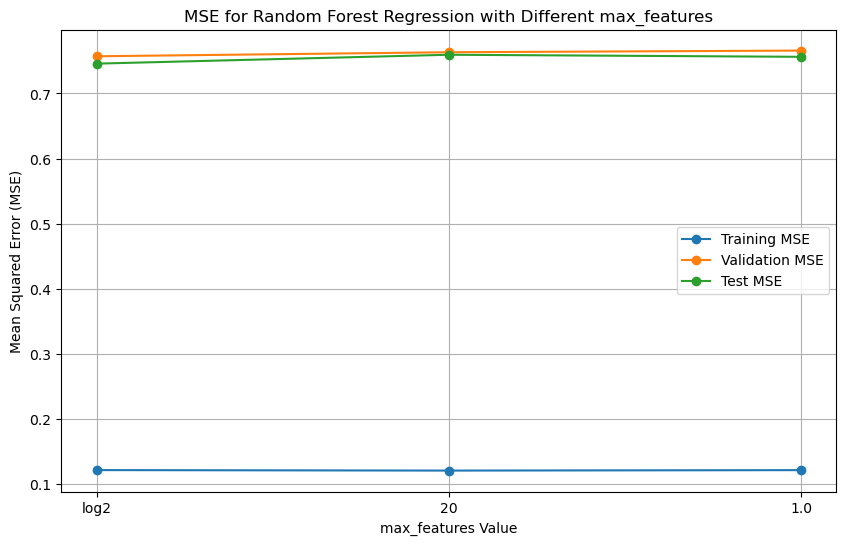

Optimal max_features: log2


/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Final Model MSE (Training): 0.1029
Final Model MSE (Validation): 0.7258
Final Model MSE (Test): 0.7181


In [135]:
# Plot MSE for different max_features values
plt.figure(figsize=(10, 6))
plt.plot(max_features_list, train_errors_rf, label="Training MSE", marker='o')
plt.plot(max_features_list, val_errors_rf, label="Validation MSE", marker='o')
plt.plot(max_features_list, test_errors_rf, label="Test MSE", marker='o')
plt.xlabel("max_features Value")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE for Random Forest Regression with Different max_features")
plt.legend()
plt.grid(True)
plt.show()

# Find the optimal max_features (minimizing validation MSE)
optimal_max_features = max_features_list[np.argmin(val_errors_rf)]
print(f"Optimal max_features: {optimal_max_features}")

# Retrain the model with the optimal max_features
final_rf_model = RandomForestRegressor(n_estimators=100, max_features=optimal_max_features, random_state=42, max_depth=None)
final_rf_model.fit(xtrain, ytrain)

# Predict on training, validation, and test sets
ytrain_pred_rf_final = final_rf_model.predict(xtrain)
yval_pred_rf_final = final_rf_model.predict(xval)
ytest_pred_rf_final = final_rf_model.predict(xtest)

# Calculate MSE for final model
train_mse_rf_final = mean_squared_error(ytrain, ytrain_pred_rf_final)
val_mse_rf_final = mean_squared_error(yval, yval_pred_rf_final)
test_mse_rf_final = mean_squared_error(ytest, ytest_pred_rf_final)

# Print the MSE for the final model
print(f"Final Model MSE (Training): {train_mse_rf_final:.4f}")
print(f"Final Model MSE (Validation): {val_mse_rf_final:.4f}")
print(f"Final Model MSE (Test): {test_mse_rf_final:.4f}")

In [ ]:
#3. Random Forest from Scrat
# Custom implementation of Random Forest Regressor
class CustomRandomForestRegressor:
    def __init__(self, n_estimators=20, max_features='log2', random_state=42):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_indices = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _select_features(self, X):
        n_features = X.shape[1]
        if self.max_features == 'log2':
            n_select = max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            n_select = min(n_features, self.max_features)
        elif self.max_features == 1.0:
            n_select = n_features
        else:
            raise ValueError("Invalid max_features setting")
        return np.random.choice(n_features, n_select, replace=False)

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.trees = []
        self.feature_indices = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            feature_idx = self._select_features(X)
            self.feature_indices.append(feature_idx)
            tree = DecisionTreeRegressor(random_state=self.random_state)
            tree.fit(X_sample[:, feature_idx], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([
            tree.predict(X[:, feature_idx]) for tree, feature_idx in zip(self.trees, self.feature_indices)
        ])
        return np.mean(predictions, axis=0)

In [138]:
# List of different max_features values to try
max_features_list = ['log2', 20, 1.0]

# Store results
train_errors_rf = []
val_errors_rf = []
test_errors_rf = []

# Train Custom Random Forest with different max_features values
for max_features in max_features_list:
    model_rf = CustomRandomForestRegressor(n_estimators=20, max_features=max_features, random_state=42)
    model_rf.fit(xtrain.values, ytrain)
    
    # Predict on training, validation, and test sets
    ytrain_pred_rf = model_rf.predict(xtrain.values)
    yval_pred_rf = model_rf.predict(xval.values)
    ytest_pred_rf = model_rf.predict(xtest.values)
    
    # Calculate MSE for training, validation, and test sets
    train_mse_rf = mean_squared_error(ytrain, ytrain_pred_rf)
    val_mse_rf = mean_squared_error(yval, yval_pred_rf)
    test_mse_rf = mean_squared_error(ytest, ytest_pred_rf)
    
    # Append results
    train_errors_rf.append(train_mse_rf)
    val_errors_rf.append(val_mse_rf)
    test_errors_rf.append(test_mse_rf)

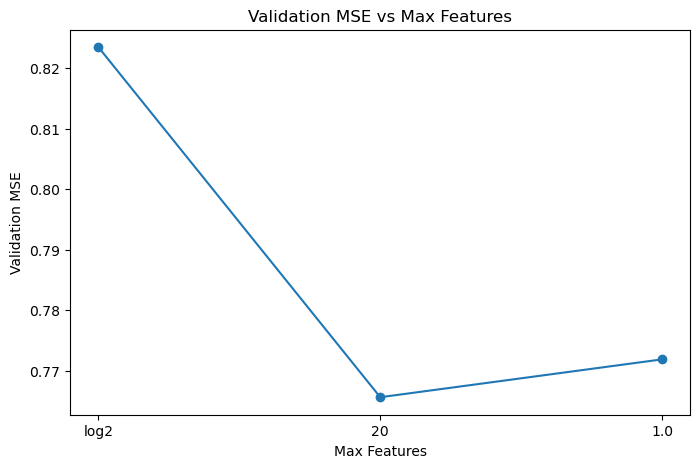

Max Features: log2
Train MSE: 0.1480
Validation MSE: 0.8234
Test MSE: 0.8098
-
Max Features: 20
Train MSE: 0.1227
Validation MSE: 0.7656
Test MSE: 0.7585
-
Max Features: 1.0
Train MSE: 0.1222
Validation MSE: 0.7719
Test MSE: 0.7542
-


In [139]:
# Plot validation error vs max_features
plt.figure(figsize=(8,5))
plt.plot(max_features_list, val_errors_rf, marker='o', linestyle='-')
plt.xlabel("Max Features")
plt.ylabel("Validation MSE")
plt.title("Validation MSE vs Max Features")
plt.show()

# Print final results
for i, max_features in enumerate(max_features_list):
    print(f"Max Features: {max_features}")
    print(f"Train MSE: {train_errors_rf[i]:.4f}")
    print(f"Validation MSE: {val_errors_rf[i]:.4f}")
    print(f"Test MSE: {test_errors_rf[i]:.4f}")
    print("-")

### Part 3 - Feature importance (7 points)



1. Compute the feature importance scores from your final models from both Part 1 and Part 2.
2. Identify the most important features for predicting the popularity score. Please report these features and provide your intuitions.

In [ ]:
### write some codes here

# Get the feature importance from Decision Tree and Random Forest
dt_feature_importances = final_rf_model.feature_importances_
rf_feature_importances = final_rf_model.feature_importances_

# Create a DataFrame to view the importance scores alongside feature names
feature_names = xtrain.columns if isinstance(xtrain, pd.DataFrame) else np.arange(xtrain.shape[1])

# Decision Tree Feature Importance
dt_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_feature_importances
}).sort_values(by='Importance', ascending=False)

# Random Forest Feature Importance
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features for both models
print("Top 10 Features for Decision Tree Regression:")
print(dt_importance_df.head(10))

print("\nTop 10 Features for Random Forest Regression:")
print(rf_importance_df.head(10))


Top 10 Features for Decision Tree Regression:
                        Feature  Importance
25                   kw_avg_avg    0.045547
24                   kw_max_avg    0.041360
28   self_reference_avg_sharess    0.031607
26    self_reference_min_shares    0.030681
39                       LDA_02    0.030173
22                   kw_avg_max    0.028333
40                       LDA_03    0.028245
38                       LDA_01    0.027927
19                   kw_avg_min    0.027200
41                       LDA_04    0.027109

Top 10 Features for Random Forest Regression:
                        Feature  Importance
25                   kw_avg_avg    0.045547
24                   kw_max_avg    0.041360
28   self_reference_avg_sharess    0.031607
26    self_reference_min_shares    0.030681
39                       LDA_02    0.030173
22                   kw_avg_max    0.028333
40                       LDA_03    0.028245
38                       LDA_01    0.027927
19                   kw_avg

2. From the top ten features above kw_avg_avg and kw_max_avg are the highest both being above .4 in importance. Furthermore, the top ten features are in the same order of importance for both the decision tree and random forest regression. 